## Regression Example

Last updated: 05.01.24

This notebook demonstrates how to use `pretrained-microscopy-models` to performance image regression.

In this example, we leverage pretrained MicroNet encoders to perform regression for fracture elongation on image patches of fractography images. We additionally, generate regression  heatmaps to identify and explain which sections of full resolution images contribute towards explantation of prediction values.

Note: Data from this study is under review and can not be publicly released. However, this notebook provides a general framework for conducting regression using pretrained MicroNet encoders.

### Import Libraries

In [17]:
''' import libraries '''

# data and file manipulation
import os
import sys
import ssl
import ast
import fcntl
import time
import copy
import random
from glob import glob
from tqdm import tqdm

import numpy as np
import pandas as pd

# image libraries
from PIL import Image
from skimage.io import imread
from skimage.color import gray2rgb
import albumentations as albu

# machine learning libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import Adam
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import segmentation_models_pytorch as smp
import pretrained_microscopy_models as pmm
import torch.utils.model_zoo as model_zoo
from scipy.stats import linregress

# import visualization
import seaborn as sns
import matplotlib.pyplot as plt

# custom functions
from dataloader import create_dataloader, create_patch_dataset
from model import generate_model, freeze_base_weights, train_model
from viz_utils import visualize_curve, prediction_scatter, r2_plot

Image.MAX_IMAGE_PIXELS = sys.maxsize
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

NVIDIA A100-SXM4-40GB


In [18]:
# establish folder paths
DATA_FOLDER = f'./data'

ENCODER = 'xception'
ENCODER_WEIGHTS = 'image-micronet'
RESIZE_FACTOR = 2
LOSS = 'mse'
TRAIN_SET_SIZE = 'full'

IMG_FOLDER = f'{DATA_FOLDER}/augmented_img_{RESIZE_FACTOR}/'
TRAIN_FOLDER = f'{DATA_FOLDER}/augmented_img_{RESIZE_FACTOR}/train_patches/'
VAL_FOLDER = f'{DATA_FOLDER}/augmented_img_{RESIZE_FACTOR}/val_patches/'

# load metadata
METADATA_PATH = f'{DATA_FOLDER}/metadata.csv'
FEATURES = ['Specimen ID', 'fracture_elongation']
NUM_FEATURES = len(FEATURES) - 1

# constant hyperparameters
LAYERS = 2

BATCH_SIZE = 16
EPOCHS = 50

LEARNING_RATE = 0.01
STEP_SIZE = 75
GAMMA = 0.1
PATIENCE = 25
PATIENCE_MIN = 50

unix_timestamp = int(time.time())
PREDICTION_PATH = fr'./outputs/{ENCODER}__{ENCODER_WEIGHTS}__resize_{RESIZE_FACTOR}__set_{TRAIN_SET_SIZE}__{unix_timestamp}__'

PATCH_SIZE = 224
STEP = 4

### Generate Datasets

In [19]:
df_metadata = pd.read_csv(METADATA_PATH)

train = glob(TRAIN_FOLDER + '*.npy')
train_loader = create_dataloader(images=train, 
                                 df=df_metadata, 
                                 features=FEATURES, 
                                 encoder=ENCODER, 
                                 set_size=TRAIN_SET_SIZE,
                                 batch_size=BATCH_SIZE)

val = glob(VAL_FOLDER + '*.npy')
val_loader = create_dataloader(images=val, 
                               df=df_metadata, 
                               features=FEATURES, 
                               encoder=ENCODER, 
                               batch_size=1024)

dataloader_dict = {'train': train_loader, 'val': val_loader}

### Instantiate Model and Train

In [20]:
''' generate model '''

model_ft = generate_model(ENCODER, ENCODER_WEIGHTS)
model_ft = freeze_base_weights(model_ft)

print("Parameters with gradient:")

params_to_update = []

for name, param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t", name)
        
optimizer_ft = Adam(params_to_update, lr=LEARNING_RATE)
scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=STEP_SIZE, gamma=GAMMA)

if LOSS == 'mse':
    criterion = nn.MSELoss()
else:
    criterion = nn.L1Loss()

model_ft = model_ft.to(device)

Parameters with gradient:
	 last_linear.0.weight
	 last_linear.0.bias
	 last_linear.2.weight
	 last_linear.2.bias
	 last_linear.4.weight
	 last_linear.4.bias


In [21]:
''' train model '''

model_ft, hist = train_model(model_ft, 
                             device, 
                             dataloader_dict, 
                             criterion, 
                             optimizer_ft,
                             scheduler,
                             patience=PATIENCE, 
                             patience_start=PATIENCE_MIN, 
                             num_epochs=EPOCHS)

Epoch 0/69
----------
Training phase:
train Loss: 393.1354
Validation phase:
val Loss: 3176.6634

Epoch 1/69
----------
Training phase:
train Loss: 410.7425
Validation phase:
val Loss: 3099.4515

Epoch 2/69
----------
Training phase:
train Loss: 550.1561
Validation phase:
val Loss: 2408.5719

Epoch 3/69
----------
Training phase:
train Loss: 446.3388
Validation phase:
val Loss: 2028.1563

Epoch 4/69
----------
Training phase:
train Loss: 426.7092
Validation phase:
val Loss: 1892.6220

Epoch 5/69
----------
Training phase:
train Loss: 419.1522
Validation phase:
val Loss: 1772.1158

Epoch 6/69
----------
Training phase:
train Loss: 406.4237
Validation phase:
val Loss: 1693.7995

Epoch 7/69
----------
Training phase:
train Loss: 416.6594
Validation phase:
val Loss: 1534.1498

Epoch 8/69
----------
Training phase:
train Loss: 420.2665
Validation phase:
val Loss: 1400.3712

Epoch 9/69
----------
Training phase:
train Loss: 419.3666
Validation phase:
val Loss: 1305.9542

Epoch 10/69
--------

### Visualize Training

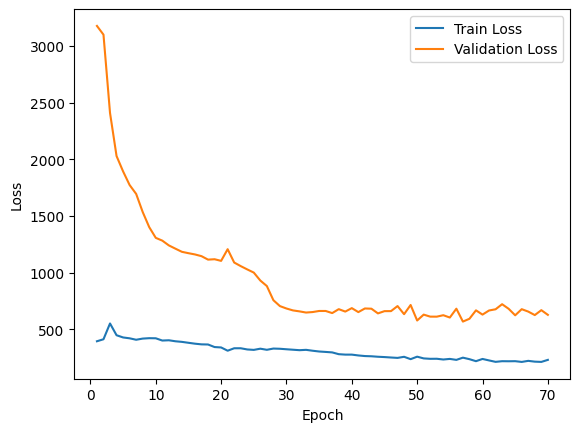

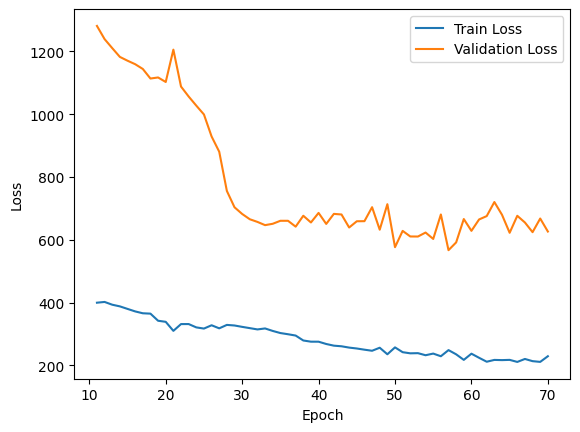

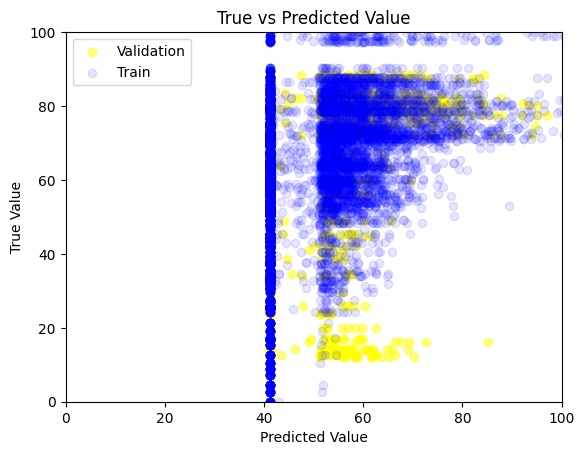

<Figure size 640x480 with 0 Axes>

In [22]:
''' generate visualizations '''

train_loss = hist[0]
val_loss = hist[1]

visualize_curve(train_loss, val_loss, save_fig=False, output_path=f'{PREDICTION_PATH}loss.png')
visualize_curve(train_loss, val_loss, start_range=10, save_fig=False, output_path=f'{PREDICTION_PATH}loss_10.png')

prediction_scatter(train_loader, val_loader, model_ft, save_fig=False, output_path=f'{PREDICTION_PATH}predictions.png')

### Generate Heatmaps: Patch Prediction

This section demonstrates how to leverate the patch_dataset to predict across all patches of the image and assemble a heatmap of predicted regression values.

In [23]:
''' patch prediction section '''

val_set = df_metadata[df_metadata['set'] == 'val']['file_path'].reset_index(drop=True)
df_pred = pd.DataFrame(columns=['file_path', 'center_pixel', 'prediction'])

for img in tqdm(val_set[0:5]):
    patches = []
    centers = []

    img_arr = imread(f'{IMG_FOLDER}{os.path.basename(img)}')
    img_shape = img_arr.shape

    h_split = np.arange(0, img_shape[0] - PATCH_SIZE, STEP)
    h_split = np.append(h_split, (img_shape[0] - PATCH_SIZE) - 1)

    w_split = np.arange(0, img_shape[1] - PATCH_SIZE, STEP)
    w_split = np.append(w_split, (img_shape[1] - PATCH_SIZE) - 1)

    for i in range(len(h_split)):
        for j in range(len(w_split)):

            # extract patch and predict
            patch = img_arr[h_split[i]:h_split[i]+PATCH_SIZE, w_split[j]:w_split[j]+PATCH_SIZE]
            patches.append(patch)

            # identify center pixel
            h_center = h_split[i] + (PATCH_SIZE / 2)
            w_center = w_split[j] + (PATCH_SIZE / 2)
            center = (h_center, w_center)
            centers.append(center)

    dataset = create_patch_dataset(patches, centers, ENCODER)
    dataloader = DataLoader(dataset, batch_size=1024)

    prediction_list = []
    locations_list = []

    with torch.no_grad():

        for data in dataloader:
            images, locations = data
            images = images.cuda()
            outputs = model_ft(images)

            outputs_arr = outputs.cpu().numpy()
            locations_arr = np.array([locations[0].numpy(), locations[1].numpy()]).T
            locations_arr = [(x, y) for x, y in zip(locations_arr[:, 0], locations_arr[:, 1])]

            prediction_list += list(outputs_arr[:,0])
            locations_list += list(locations_arr)

    df_temp = pd.DataFrame({'file_path': img, 'center_pixel': locations_list, 'prediction': prediction_list})
    df_pred = pd.concat([df_pred, df_temp], axis=0)

    print(f'finished: {img}')

 20%|██        | 1/5 [00:09<00:39,  9.98s/it]

finished: /acp/data/jstuckner_shared/training_data/SLS Weld Fractography 2023 /2023-RCI-010-T1A.TIF



 40%|████      | 2/5 [00:18<00:28,  9.37s/it]

finished: /acp/data/jstuckner_shared/training_data/SLS Weld Fractography 2023 /2023-RCI-010-T1B.TIF



 60%|██████    | 3/5 [00:28<00:18,  9.33s/it]

finished: /acp/data/jstuckner_shared/training_data/SLS Weld Fractography 2023 /2023-RCI-010-T2A.TIF



 80%|████████  | 4/5 [00:40<00:10, 10.65s/it]

finished: /acp/data/jstuckner_shared/training_data/SLS Weld Fractography 2023 /2023-RCI-010-T2B.TIF


100%|██████████| 5/5 [00:50<00:00, 10.09s/it]

finished: /acp/data/jstuckner_shared/training_data/SLS Weld Fractography 2023 /2023-RCI-010-T3A.TIF


In [ ]:
''' assemble images with heatmaps '''

parent_feature = 'Fracture elongation (%)'
feature = 'fracture_elongation'

heatmaps = []
img_arrs = []
v_values = []    

for img in df_pred['file_path'].unique():
    print(f'Generating heatmap for: {os.path.basename(img)}')

    img_path = f'{BASE_FOLDER}{os.path.basename(img)}'
    real_value = df_metadata.loc[df_metadata['file_path'] == img_path, parent_feature].values[0]
    norm_value = df_metadata.loc[df_metadata['file_path'] == img_path, feature].values[0]

    # load and preprocess image
    img_arr = imread(f'{IMG_FOLDER}{os.path.basename(img)}')

    # filter to predictions for image
    df_heatmap = df_pred[df_pred['file_path'] == img].reset_index(drop=True)

    # create heatmap
    heatmap = np.zeros((img_arr.shape[0], img_arr.shape[1]), dtype=np.float32)
    coords = df_heatmap['center_pixel']
    values = df_heatmap['prediction']

    # iterate over coordinates
    for i, coord in enumerate(coords):
        coord = ast.literal_eval(str(coord))
        x = int(coord[0])
        y = int(coord[1])

        box_size = int(STEP / 2)
        # set coordinate to pixel value
        heatmap[x-box_size:x+box_size, y-box_size:y+box_size] = values[i]

    heatmaps.append(heatmap)
    img_arrs.append(img_arr)
    v_values.append([np.quantile(heatmap[112:-112, 112:-112], 0.15), np.quantile(heatmap[112:-112, 112:-112], 0.85)])

for i in range(2):
    plt.imshow(img_arrs[i][112:-112, 112:-112])
    plt.axis('off')

    # Plot the Seaborn heatmap over the image
    sns.heatmap(heatmaps[i][112:-112, 112:-112],  
                cmap='RdBu', 
                alpha=0.3, 
                vmin=v_values[i][0], 
                vmax=v_values[i][1],
                cbar=False)

    # Adjust subplot spacing
    plt.tight_layout()
    plt.show()
    plt.clf()

![alt text](demo.png)

![alt text](demo_1.png)

### Generate R2 Regression Plots

In [29]:
''' summarize predictions '''

# group by image and get statistics
df_summ = df_pred.groupby('file_path', as_index=False).agg(
    {'prediction': ['mean', 'min', 'max', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)]})

# clean up dataframe
df_summ = df_summ.droplevel(axis=1, level=0)
df_summ.columns = ['file_path', 'mean', 'min', 'max', 'q25', 'q75']

# merge original feature values
df_summ = df_summ.merge(df_metadata, how='left', on='file_path')

In [ ]:
''' r_squared plots '''

min_r_squared = r2_plot(df_summ, 'fracture_elongation', 'min', save_fig=False, output_path=f'{PREDICTION_PATH}r_max.png')
max_r_squared = r2_plot(df_summ, 'fracture_elongation', 'max', save_fig=False, output_path=f'{PREDICTION_PATH}r_min.png')
mean_r_squared = r2_plot(df_summ, 'fracture_elongation', 'mean', save_fig=False, output_path=f'{PREDICTION_PATH}r_mean.png')

custom_r_squared = (min_r_squared + max_r_squared) / 2

### Save Model Metrics

In [18]:
''' save metrics '''
best_train_loss = min(train_loss)
best_val_loss = min(val_loss)

new_row = pd.DataFrame({'NN': [MODEL_NUM], 
                        'resize_factor': [RESIZE_FACTOR], 
                        'encoder': [ENCODER], 
                        'encoder_weights': [ENCODER_WEIGHTS], 
                        'loss': [LOSS], 
                        'best_train_loss': [best_train_loss], 
                        'best_val_loss': [best_val_loss], 
                        'min_r': [min_r_squared], 
                        'max_r': [max_r_squared], 
                        'mean_r': [mean_r_squared], 
                        'r_squared': [custom_r_squared],
                        'unix_timestamp': [unix_timestamp]})

metrics_file = f'./outputs/metrics.csv'

# if the file already exists, append a row
if os.path.isfile(metrics_file):
    df_metrics = pd.read_csv(metrics_file)
    
    # lock to avoid multiple writes
    with open(metrics_file, 'a') as file:
        # lock file
        fcntl.flock(file, fcntl.LOCK_EX)

        df_metrics = pd.concat([df_metrics, new_row])
        df_metrics.to_csv(metrics_file, index=False)

        fcntl.flock(file, fcntl.LOCK_UN)
# create file if it does not exist
else:
    df_metrics = new_row
    df_metrics.to_csv(metrics_file, index=False)

In [19]:
''' save model '''

torch.save(model_ft.state_dict(), f'{PREDICTION_PATH}model.pth')